In [46]:
import pandas as pd
import numpy as np
import os
import sys
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
import matplotlib.patches as npatches

In [2]:
# Reproducible results
random_state = 42
np.random.seed(random_state)

# Data

In [3]:
def get_data(one_hot_enc=True, reshape=False, train_val_test=False):
    DATA_PATH = "../data/"
    file_list = os.listdir(DATA_PATH)
    images_path = file_list[0]
    labels_path = file_list[1]
    images_path_full = os.path.join(DATA_PATH + images_path)
    labels_path_full = os.path.join(DATA_PATH + labels_path)
    X = pd.read_csv(images_path_full)
    if reshape:
        X = X.values.astype('float32')
        # Normalize data
        X = X / 255
        # Reshape for cnn 
        X = X.reshape([-1, 28, 28, 1]).astype('float32')
    else:
        # Normalize data
        X = X / 255
    y = pd.read_csv(labels_path_full)
    # Encode labels
    if one_hot_enc:
        encoder = OneHotEncoder(sparse=False, categories='auto')
        y = encoder.fit_transform(y)
    # Divide into train and test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    if train_val_test:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

In [4]:
def print_data_shapes_val(X_train, X_val, X_test, y_train, y_val, y_test):
    print("X_train_nn: ", X_train.shape)
    print("X_val_nn: ", X_val.shape)
    print("X_test_nn: ", X_test.shape)
    print("y_train_nn: ", y_train.shape)
    print("y_val_nn: ", y_val.shape)
    print("y_test_nn: ", y_test.shape)

In [5]:
def print_data_shapes_nval(X_train, X_test, y_train, y_test):
    print("X_train_nn: ", X_train.shape)
    print("X_test_nn: ", X_test.shape)
    print("y_train_nn: ", y_train.shape)
    print("y_test_nn: ", y_test.shape)

# Classifiers

In [6]:
classifiers_dict = {}

In [7]:
model_folder_path = "../models/"

In [65]:
learning_rate = 1e-3
optimizer = Adam(lr=learning_rate)

### Feed Forward Neural Net

In [66]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras import regularizers
import keras

In [67]:
X_train_nn, X_val_nn, X_test_nn, y_train_nn, y_val_nn, y_test_nn = get_data(train_val_test=True)

In [68]:
model_name_nn = "MNIST_nn"
model_name_ext_nn = ".hdf5"
full_path_nn = model_folder_path + model_name_nn + model_name_ext_nn

In [69]:
# Load the model
model_nn = keras.models.load_model(full_path_nn)

In [70]:
# Params

# Model compile
metrics = ['accuracy']
loss = 'categorical_crossentropy'

# Model architecture
regularizer_l2 = regularizers.l2(0.01)

# Model fit
epochs = 12
batch_size = 64

In [71]:
print_data_shapes_val(X_train_nn, X_val_nn, X_test_nn, y_train_nn, y_val_nn, y_test_nn)

X_train_nn:  (39199, 784)
X_val_nn:  (16800, 784)
X_test_nn:  (14000, 784)
y_train_nn:  (39199, 10)
y_val_nn:  (16800, 10)
y_test_nn:  (14000, 10)


In [72]:
model_nn = Sequential()
model_nn.add(Dense(256, input_dim=784, activation='relu', kernel_regularizer=regularizer_l2))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(8, activation='relu', kernel_regularizer=regularizer_l2))
model_nn.add(Dense(10, activation='softmax'))

In [73]:
model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [74]:
start_nn = time.time()
history_nn = model_nn.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=epochs, batch_size=batch_size)
end_nn = time.time()
scores_nn = model_nn.evaluate(X_test_nn, y_test_nn)

Train on 39199 samples, validate on 16800 samples
Epoch 1/12
39199/39199 [==============================] - 7s 170us/step - loss: 1.0281 - acc: 0.8103 - val_loss: 0.5010 - val_acc: 0.9202
Epoch 2/12
39199/39199 [==============================] - 6s 153us/step - loss: 0.4349 - acc: 0.9339 - val_loss: 0.4002 - val_acc: 0.9427
Epoch 3/12
39199/39199 [==============================] - 6s 154us/step - loss: 0.3735 - acc: 0.9457 - val_loss: 0.3541 - val_acc: 0.9493
Epoch 4/12
39199/39199 [==============================] - 6s 157us/step - loss: 0.3264 - acc: 0.9522 - val_loss: 0.3210 - val_acc: 0.9526
Epoch 5/12
39199/39199 [==============================] - 6s 156us/step - loss: 0.2979 - acc: 0.9563 - val_loss: 0.3142 - val_acc: 0.9529
Epoch 6/12
39199/39199 [==============================] - 6s 156us/step - loss: 0.2799 - acc: 0.9604 - val_loss: 0.2657 - val_acc: 0.9620
Epoch 7/12
39199/39199 [==============================] - 6s 156us/step - loss: 0.2662 - acc: 0.9608 - val_loss: 0.2968 - 

In [75]:
tot_nn = round(end_nn - start_nn, 2)

In [76]:
print("Scores: ", scores_nn, "\n Training time: ", tot_nn, " seconds")

Scores:  [0.2433919607741492, 0.9611428571428572] 
 Training time:  75.03  seconds


> Can see that the model is somewhat overfitting - Will try to implement *Regularizer*
<br>
This resulted in a loss in accuracy, but there is a trade off between accuracy and overfitting

In [77]:
classifiers_dict['NN'] = {'accuracy': scores_nn[1], 'time': tot_nn}

In [78]:
keras.models.save_model(model_nn, full_path_nn)

### CNN

In [9]:
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.datasets import mnist
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

In [10]:
X_train_cnn, X_val_cnn, X_test_cnn, y_train_cnn, y_val_cnn, y_test_cnn = get_data(one_hot_enc=False, reshape=True, train_val_test=True)

In [11]:
y_train_cnn = np_utils.to_categorical(y_train_cnn)
y_val_cnn = np_utils.to_categorical(y_val_cnn)
y_test_cnn = np_utils.to_categorical(y_test_cnn)

In [12]:
print_data_shapes_val(X_train_cnn, X_val_cnn, X_test_cnn, y_train_cnn, y_val_cnn, y_test_cnn)

X_train_nn:  (39199, 28, 28, 1)
X_val_nn:  (16800, 28, 28, 1)
X_test_nn:  (14000, 28, 28, 1)
y_train_nn:  (39199, 10)
y_val_nn:  (16800, 10)
y_test_nn:  (14000, 10)


In [13]:
model_name_cnn = "MNIST_cnn"
model_name_ext_cnn = ".hdf5"
full_path_cnn = model_folder_path + model_name_cnn + model_name_ext_cnn

In [45]:
# Load the model
# model_cnn = keras.models.load_model(full_path_cnn)

In [14]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.4))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))

> Tried implementing with GridSearchCV, but it seems there is a problem with combining Keras Classifier and GridSearchCV

https://stackoverflow.com/questions/48717451/keras-kerasclassifier-gridsearch-typeerror-cant-pickle-thread-lock-objects

In [39]:
start_cnn = time.time()
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=4, batch_size=200)
end_cnn = time.time()
scores_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn)

Train on 39199 samples, validate on 16800 samples
Epoch 1/4
39199/39199 [==============================] - 20s 515us/step - loss: 0.1929 - acc: 0.9382 - val_loss: 0.0729 - val_acc: 0.9785
Epoch 2/4
39199/39199 [==============================] - 21s 543us/step - loss: 0.0611 - acc: 0.9799 - val_loss: 0.0652 - val_acc: 0.9789
Epoch 3/4
39199/39199 [==============================] - 25s 642us/step - loss: 0.0438 - acc: 0.9863 - val_loss: 0.0514 - val_acc: 0.9842
Epoch 4/4
14000/14000 [==============================] - 4s 306us/step


In [44]:
tot_cnn = round(end_cnn - start_cnn, 2)

In [41]:
print("Scores: ", scores_cnn, "\n Training time: ", tot_cnn, " seconds")

Scores:  [0.04565956243426938, 0.9862142857142857] 
 Training time:  90.88  seconds


In [140]:
classifiers_dict['CNN'] = {'accuracy': scores_cnn[1], 'time': tot_cnn}

In [43]:
# Save the model
keras.models.save_model(model_cnn, full_path_cnn)

### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [50]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = get_data()

In [51]:
print_data_shapes_nval(X_train_rf, X_test_rf, y_train_rf, y_test_rf)

X_train_nn:  (55999, 784)
X_test_nn:  (14000, 784)
y_train_nn:  (55999, 10)
y_test_nn:  (14000, 10)


In [52]:
model_name_rf = "MNIST_Random_Forest"
model_name_ext_rf = ".pickle.dat"
full_path_rf = model_folder_path + model_name_rf + model_name_ext_rf

In [53]:
# Load model
random_f_clf = pickle.load(open(full_path_rf, "rb"))

In [54]:
random_f_clf = RandomForestClassifier(n_estimators=50,
                                     n_jobs = 2,
                                     random_state=random_state)
start_rf = time.time()
random_f_clf.fit(X_train_rf, y_train_rf)
end_rf = time.time()

In [55]:
tot_rf = round(end_rf - start_rf, 2)

In [56]:
y_pred_rf = random_f_clf.predict(X_test_rf)
scores_rf = accuracy_score(y_test_rf, y_pred_rf)

In [57]:
print("Scores: ", scores_rf, "\n Training time: ", tot_rf, " seconds")

Scores:  0.8957857142857143 
 Training time:  15.95  seconds


In [58]:
classifiers_dict['RF'] = {'accuracy': scores_rf, 'time': tot_rf}

In [133]:
# Save the model
pickle.dump(random_f_clf, open(full_path_rf, "wb"))

### XGBoost

In [34]:
# If needing to install xgboost (using conda)
# ! conda install py-xgboost

In [153]:
from xgboost import XGBClassifier

In [154]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = get_data(one_hot_enc=False)

In [155]:
print_data_shapes_nval(X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb)

X_train_nn:  (55999, 784)
X_test_nn:  (14000, 784)
y_train_nn:  (55999, 1)
y_test_nn:  (14000, 1)


In [156]:
model_name_xgb = "MNIST_XGBoost"
model_name_ext_xgb = ".pickle.dat"
full_path_xgb = model_folder_path + model_name_xgb + model_name_ext_xgb

### NOTE: If you want to save time - load the model. 

In [157]:
# Load the model
# optim_est_xgb = pickle.load(open(full_path_xgb), "rb")

In [158]:
params = {
        'gamma': [0.5, 2],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 5],
        'n_estimators': [5, 10]
        }

Fun to try with more parameters, but my poor CPU cannot take any more..

## Disclaimer: This takes a lot of time

In [159]:
%%capture 
xgb_clf = XGBClassifier()
rs = GridSearchCV(xgb_clf,
                  params,
                  cv=2,
                  scoring="accuracy",
                  n_jobs=1,
                  verbose=2)
start_xgb = time.time()
rs.fit(X_train_xgb, y_train_xgb.values.ravel())
end_xgb = time.time()

In [160]:
optim_est_xgb = rs.best_estimator_
print(optim_est_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)


In [161]:
tot_xgb = round(end_xgb - start_xgb, 2)

In [162]:
y_pred_xgb = optim_est_xgb.predict(X_test_xgb)
scores_xgb = accuracy_score(y_test_xgb, y_pred_xgb)

In [163]:
print("Scores: ", scores_xgb, "\n Training time: ", tot_xgb, " seconds")

Scores:  0.9046428571428572 
 Training time:  2489.19  seconds


In [164]:
classifiers_dict['XGB'] = {'accuracy': scores_xgb, 'time': tot_xgb}

In [165]:
pickle.dump(optim_est_xgb, open(full_path_xgb, "wb"))

> Saving the dictionary to file

In [31]:
dictionary_path = "../dictionaries/"
classifiers_dict_f_name = "classifiers_dict.npy"
classifiers_dict_f_path = dictionary_path + classifiers_dict_f_name

In [167]:
np.save(classifiers_dict_f_path, classifiers_dict)

## Evaluating

In [47]:
# To load the classifiers dict:
classifiers_dict = np.load(classifiers_dict_f_path).item()

In [48]:
classifiers_dict

{'NN': {'accuracy': 0.9642142857142857, 'time': 94.46},
 'CNN': {'accuracy': 0.9862142857142857, 'time': 90.88},
 'RF': {'accuracy': 0.8957857142857143, 'time': 16.93},
 'XGB': {'accuracy': 0.9046428571428572, 'time': 2489.19}}

In [36]:
accuracy_list = []
time_list = []
classifiers_list = []
for k, v in classifiers_dict.items():
    classifiers_list.append(k)
    accuracy_list.append(classifiers_dict[k]['accuracy'])
    time_list.append(classifiers_dict[k]['time'])

> I want to plot both time and accuracy in the same plot, for the different classifiers, but accuracy ranges from 0-1, while time ranges from approximately 16 seconds to 2500 seconds. This means I have to normalize the time values, so that they are between 0 and 1.

In [42]:
# normalize time list
normalizing_constant = max(time_list)
for i in range(len(time_list)):
    time_list[i] = time_list[i]/normalizing_constant
    print(time_list[i])

0.0379480875304818
0.036509868672138325
0.006801409293786332
1.0


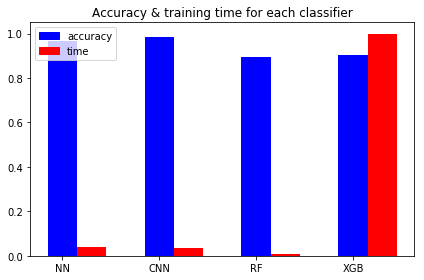

In [63]:
y_pos = np.arange(len(classifiers_list))
bar_width = 0.3
plt.bar(y_pos, accuracy_list, width=bar_width, color='b', align='center')
plt.bar(y_pos + bar_width, time_list, width=bar_width, color='r', align='center')
plt.xticks(y_pos, classifiers_list)
plt.title('Accuracy & training time for each classifier')

blue = npatches.Patch(color='blue', label='accuracy')
red = npatches.Patch(color='red', label='time')

plt.legend(handles=[blue, red])
plt.tight_layout()
plt.show()

> Pretty simple to see that XGBoost is poluting the plot - remove it, and try again, to get a better look at the actually successfull models

In [103]:
xgb_index = classifiers_list.index('XGB')
accuracy_list.pop(xgb_index)
time_list.pop(xgb_index)
classifiers_list.pop(xgb_index)

'XGB'

> Still have to normalize time values 

In [104]:
normalizing_constant = max(time_list)
for i in range(len(time_list)):
    time_list[i] = time_list[i]/normalizing_constant
    print(time_list[i])

1.0
0.9621003599407156
0.1792293034088503


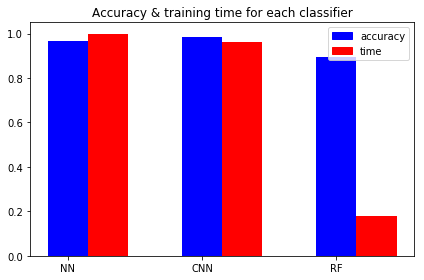

In [105]:
y_pos = np.arange(len(classifiers_list))
bar_width = 0.3
plt.bar(y_pos, accuracy_list, width=bar_width, color='b', align='center')
plt.bar(y_pos + bar_width, time_list, width=bar_width, color='r', align='center')
plt.xticks(y_pos, classifiers_list)
plt.title('Accuracy & training time for each classifier')

blue = npatches.Patch(color='blue', label='accuracy')
red = npatches.Patch(color='red', label='time')

plt.legend(handles=[blue, red])
plt.tight_layout()
plt.show()

Can see that NN and CNN are relatively equal, and far superior to Random Forest - accuracy-wise. Random Forest on the other hand is much better time-wise. If the data set would've required computation time equal to many hours, then Random Forest would probably be the most relevant model, at least for a starter model. However, the difference in time is approximately 1 minute, while the accuracy difference is ~ 10%.  

## Looking at the data

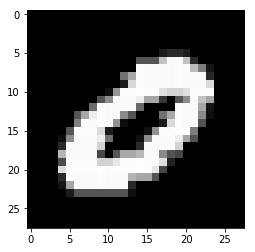

In [87]:
plt.imshow(X_train_cnn[3].reshape(28, 28), cmap='gray')

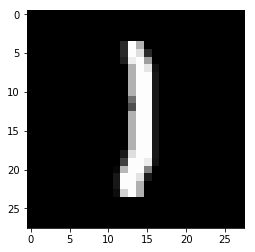

In [88]:
plt.imshow(X_train_cnn[0].reshape(28, 28), cmap='gray')

### Plots

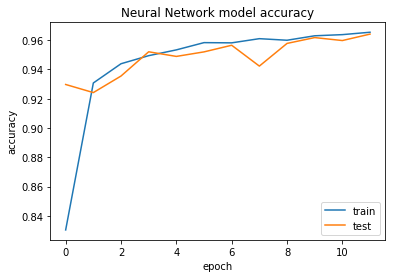

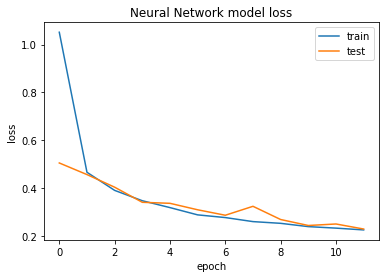

In [53]:
plt.plot(history_nn.history['acc'])
plt.plot(history_nn.history['val_acc'])
plt.title('Neural Network model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.title('Neural Network model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

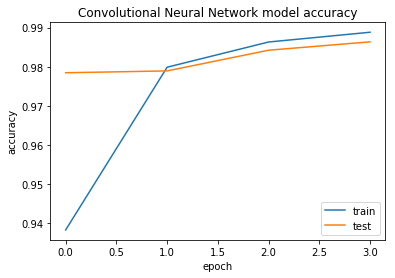

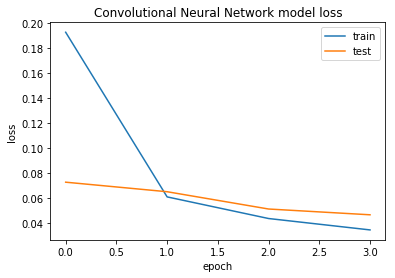

In [54]:
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('Convolutional Neural Network model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Convolutional Neural Network model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

> Looks like the CNN is overfitting - should probably implement some regularization techniques to combat this. Will do this in the next section when tuning hyperparameters. 

# Conclusion

It is pretty clear that neural networks are the way to go, more specifically that convolutional neural networks are superior at recognizing images (confirming every experiment made since cnn's were invented). 

With this in mind it seems only necessary to do hyperparameter tuning for the aformentioned cnn. 

In [81]:
def create_cnn_model(optimizer, activation='relu', pool_size=(2, 2)):
    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation=activation))
    model_cnn.add(MaxPooling2D(pool_size=(pool_size)))
    model_cnn.add(Dropout(0.4))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation=activation))
    model_cnn.add(Dense(10, activation='softmax'))
    model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model_cnn

In [96]:
batch_size = [20, 80, 160]
epochs = [5, 10, 20]
learning_rate = [1e-1, 1e-2, 1e-3]
pool_size = [(1, 1), (2, 2), (3, 3)]
activation = ['relu', 'tanh']
classifier_cnn = {}

> **NOTE** <br>
Do not find it necessary to test other optimizers other than Adam, seeing as this combines the best of two worlds: Momentum with RMSprop

In [97]:
X_train_cnn, X_val_cnn, X_test_cnn, y_train_cnn, y_val_cnn, y_test_cnn = get_data(one_hot_enc=False, reshape=True, train_val_test=True)

In [98]:
y_train_cnn = np_utils.to_categorical(y_train_cnn)
y_val_cnn = np_utils.to_categorical(y_val_cnn)
y_test_cnn = np_utils.to_categorical(y_test_cnn)

In [99]:
print_data_shapes_nval(X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn)

X_train_nn:  (39199, 28, 28, 1)
X_test_nn:  (14000, 28, 28, 1)
y_train_nn:  (39199, 10)
y_test_nn:  (14000, 10)


In [100]:
start_cnn_optim = time.time()
counter = 0
for batch_size in batch_size:
    for epochs in epochs:
        for lr in learning_rate:
            optim = Adam(lr=lr)
            for pool_size in pool_size:
                for activation in activation:
                    start_cnn_optim_each_model = time.time()
                    model_cnn_optim = create_cnn_model(optimizer=optim, 
                                             activation=activation, 
                                             pool_size=pool_size)
                    model_cnn_optim.fit(X_train_cnn, 
                              y_train_cnn, 
                              validation_data=(X_val_cnn, y_val_cnn), 
                              epochs=epochs, 
                              batch_size=batch_size)
                    
                    scores_cnn_optim = model_cnn_optim.evaluate(X_test_cnn, y_test_cnn)
                    
                    end_cnn_optim_each_model = time.time()
                    total_cnn_optim_each_model = end_cnn_optim_each_model - start_cnn_optim_each_model
                    classifier_cnn[counter] = {'parameters':
                                               {
                                                   'batch_size': batch_size,
                                                   'epochs': epochs,
                                                   'learning-rate': lr,
                                                   'pool-size': pool_size,
                                                   'activation': activation
                                               }, 
                                               'scores': 
                                               {
                                                   'loss': scores_cnn_optim[0],
                                                   'accuracy': scores_cnn_optim[1]
                                               },
                                               'time': total_cnn_optim_each_model
                                              }
                    counter += 1
                    
                    
end_cnn_optim = time.time()
total_cnn_optim = end_cnn_optim - start_cnn_optim


Train on 39199 samples, validate on 16800 samples
Epoch 1/5
 9600/39199 [======>.......................] - ETA: 1:05 - loss: 14.6686 - acc: 0.0881

KeyboardInterrupt: 